In [1]:
import numpy as np
rd_st = np.random.RandomState(42)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
import osmnx as ox
import shapely
import warnings
warnings.filterwarnings('ignore')

import multiprocessing
from multiprocessing import Pool

import time
import ipdb
from IPython import display

%matplotlib inline

In [2]:
from rider import *

# Load data, road network

In [3]:
rand_merchant = np.random.choice(nodes['NodeName'], 20)
rand_merchant

array([6427489836, 4593677856, 1709836255,  960396150, 1842846123,
       6265406984, 2642043199, 5282422183, 8233441850, 6056451834,
       7030663132, 4673548170,  440562407, 4598923536, 4604856683,
       2327166645,  250073111, 2684762386, 2507225686,   25455304])

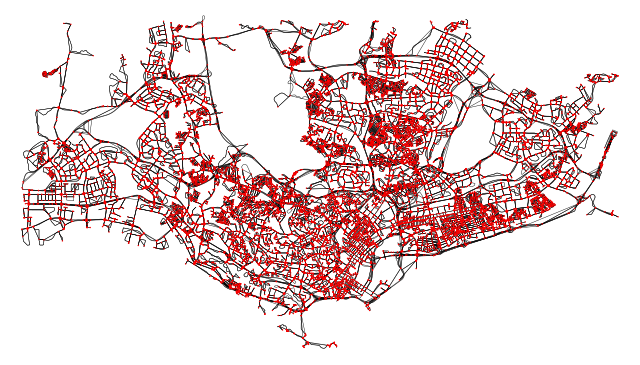

In [4]:
fig, ax = ox.plot.plot_graph(
    G_sgp, node_size=1, node_color='r', bgcolor='w', edge_color='k',
    edge_linewidth=.3, save=0, show=False, close=False
)

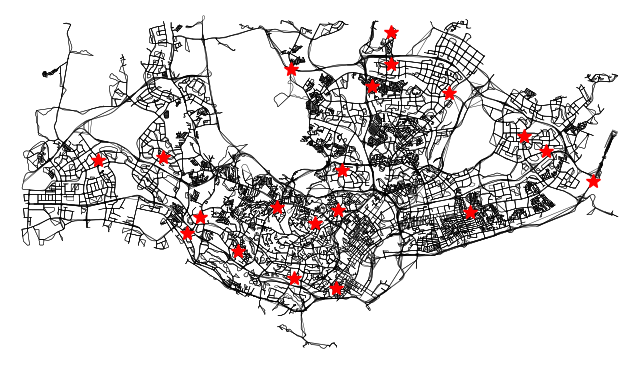

In [4]:
fig, ax = ox.plot.plot_graph(
    G_sgp, node_size=0, bgcolor='w', edge_color='k',
    edge_linewidth=.3, save=0, show=False, close=False
)

for i in rand_merchant:
    ax.plot(
        nodes.loc[nodes['NodeName']==i, 'x'].values[0],
        nodes.loc[nodes['NodeName']==i, 'y'].values[0],
        'r*', markersize=10)


In [5]:
# defined in rider.py
nodes.head()

,NodeName,x,y
0,25451915,103.978767,1.334762
1,25451918,103.973936,1.327573
2,25451929,103.872544,1.295232
3,25455287,103.874004,1.295445
4,25455292,103.908497,1.301013


In [6]:
# defined in rider.py
edges.head()

,EdgeName,from,to,distance,osmid,maxspeed,travel_time_minimum
0,0,25451915,25451918,0.963113,"[166741187, 649636776, 649636777, 717446235, 2...",90,0.010701
1,1,25451918,242636478,0.278409,22617511,50,0.005568
2,2,25451918,1143899970,0.670252,166741192,90,0.007447
3,3,25451929,6749812859,0.765032,"[49961799, 718881456, 741164883, 754786742, 17...",70,0.010929
4,4,25455287,1637003462,0.629055,150829205,50,0.012581


Try Dijkstra method

# Define rider

In [7]:
# in rider.py

# Define platform


In [8]:
class platform:
    def __init__(self, r, cR, k, t):
        self.customer_df = pd.DataFrame(
            [],
            columns=[
                'node_ID',
                'merchant_node',
                'waiting_time',
                'position_x',
                'position_y'
            ]
        )

        self.matched_customer_df = pd.DataFrame(
            [],
            columns=[
                'node_ID',
                'merchant_node',
                'waiting_time',
                'position_x',
                'position_y'
            ]
        )
        
        self.num_accumulated_order = 0
        self.r = r
        self.cR = cR
        self.k = k
        self.t = t
    
    def update_cust_df_with_new_rand_num_cust(self, n=1):
        c = 0
        while True and n > 0:
            ind = self.customer_df.shape[0]
            node_ID = rd_st.choice(list(nodes['NodeName']))
            node_position = get_node_xy(node_ID)
            merchant_node = rd_st.choice(merchant_node_set)
            
            if np.linalg.norm(node_position - get_node_xy(merchant_node)) * 111 < cR:
                new_customer = pd.DataFrame(
                    [[node_ID, merchant_node, 0, node_position[0], node_position[1]]],
                    index=[ind],
                    columns=['node_ID', 'merchant_node', 'waiting_time', 'position_x', 'position_y']
                )
                self.customer_df = pd.concat([self.customer_df, new_customer], axis=0, ignore_index=True)
                c = c + 1
                
            if c == n:
                break
    
    def acquire_order(self, q):
        # num_generated_order_c is continuous ('_c'), not discrete
        num_generated_order_c = rd_st.rand() * q * t_resolution * 2
        self.num_accumulated_order += num_generated_order_c
        num_generated_order = int(self.num_accumulated_order - self.customer_df.shape[0])
        
        self.update_cust_df_with_new_rand_num_cust(num_generated_order)
        
        self.customer_df['waiting_time'] = self.customer_df['waiting_time'] + t_resolution
        self.matched_customer_df['waiting_time'] = self.matched_customer_df['waiting_time'] + t_resolution

    def update_matched_order(self, matched_batches):
        for i in matched_batches.flatten():
            first_cust_ind = self.customer_df.loc[self.customer_df['node_ID']==i, 'waiting_time'].astype(float).idxmax()
            self.matched_customer_df = self.matched_customer_df.append(self.customer_df.loc[first_cust_ind])
            self.customer_df = self.customer_df.drop(index=first_cust_ind)
        
        self.matched_customer_df.index = range(self.matched_customer_df.shape[0])
        self.customer_df.index = range(self.customer_df.shape[0])
        
        self.num_accumulated_order -= matched_batches.size
    
    def match(self, idle_rider_IDs, rider_set):
        # when multiprocessing, the rider ID and index of each rider
        # in the rider_set list are not necessarily the same
        rider_ID_set = [i.ID for i in rider_set]
        rider_index_df = pd.DataFrame(range(len(rider_ID_set)), index=rider_ID_set, columns=['ind'])
        
        matched_batches = []
        matched_rider_IDs = []
        matched_merchants = []
        
        for i in range(len(merchant_node_set)):
            # first find corresponding idle rider IDs
            merchant_node = merchant_node_set[i]
            idle_rider_IDs_this_merchant = []
            for idle_rider_ID in idle_rider_IDs:
                idle_rider = rider_set[rider_index_df.loc[idle_rider_ID, 'ind']]
                if idle_rider.closest_merchant_node==merchant_node:
                    idle_rider_IDs_this_merchant.append(idle_rider_ID)
            n_idle_riders_this_merchant = len(idle_rider_IDs_this_merchant)
            
            # accumulatd orders for this merchant
            acc_ord_this_mer_df = self.customer_df.loc[self.customer_df['merchant_node']==merchant_node]
            acc_ord_this_mer = acc_ord_this_mer_df['node_ID'].astype(int).values
            
            num_required_riders_this_merchant = min(
                n_idle_riders_this_merchant,
                # number of accumulated orders for this merchant // k
                len(acc_ord_this_mer) // self.k
            )
            
            matched_rider_IDs_this_merchant = list(rd_st.choice(
                idle_rider_IDs_this_merchant,
                num_required_riders_this_merchant,
                replace=False
            ))

            matched_batches_this_merchant = []
            for j in range(len(matched_rider_IDs_this_merchant)):
                matched_batches_this_merchant.append(acc_ord_this_mer[self.k*j:self.k*(j+1)])
                matched_merchants.append(merchant_node)
            matched_batches_this_merchant = np.array(matched_batches_this_merchant)
            
            matched_batches.extend(matched_batches_this_merchant)
            matched_rider_IDs.extend(matched_rider_IDs_this_merchant)

        matched_batches = np.array(matched_batches)
        # remove the matched orders
        self.update_matched_order(matched_batches)
        W_cq_4_matched_customers = []
        for i in np.array(matched_batches).flatten():
            W_cq_4_matched_customers.append(self.customer_df['waiting_time'])
        avg_W_cq = np.mean(W_cq_4_matched_customers) if len(W_cq_4_matched_customers)>0 else np.nan
        
        # their indexes are mutually matched
        return matched_batches, matched_rider_IDs, matched_merchants, avg_W_cq  
        

In [9]:
# Multi processing, but it is slower if the step length is small, say, one
def move_all_riders():
    # number of riders at each process
    N_each_process = N // (n_cpu - 1) if N%n_cpu != 0 else N // n_cpu
    n_process = N//N_each_process+1 if N%N_each_process != 0 else N//N_each_process

    params = []
    for i in range(n_process):
        params.append(
            [
                rider_set[i*N_each_process:(i+1)*N_each_process],
                t_resolution,
                matched_rider_IDs,
                matched_batches,
                matched_merchants,
                dec_var
            ]
        )
    
    moved_rider_set = pool.starmap(func=move_rider, iterable=params )
    return moved_rider_set


In [10]:
config_set = []
rider_set = []
N = 300
q_bar = 300
r = 2
cR = 4
k = 3
t = 0.005

Delta = cR
t_resolution = 0.01
match_period = t//t_resolution if t%t_resolution==0 else t//t_resolution+1

dec_var = {
    'r': r,
    'cR': cR,
    'k': k,
    't': t,
    'N': N,
    'q_bar': q_bar
}

merchant_node_set = rand_merchant

In [11]:
# born of riders
num_new_riders = N


num_exist_riders = len(rider_set)
new_rider_count = 0
while new_rider_count < num_new_riders:
    config_i = {
        'ID': num_exist_riders + new_rider_count,
        'initial_position': np.array(
            [rd_st.rand() * (nodes['x'].max() - nodes['x'].min()) + nodes['x'].min(),
             rd_st.rand() * (nodes['y'].max() - nodes['y'].min()) + nodes['y'].min()]
        ),
        'maxspeed': rd_st.randint(10, 20) / 111  # transfer from km to lon-lat
    }
    rider_i = rider(config_i, dec_var, merchant_node_set, rd_st)
    
    config_set.append(config_i)
    rider_set.append(rider_i)
    
    new_rider_count += 1

In [12]:
virtual_plat = platform(r, cR, k, t)

In [13]:
c = 0
x_axis = []
num_idle_rider_IDs_set = []
num_accumulated_batch_set = []
p_set = []
pp_set = []
avg_W_cq_set = []

In [14]:
n_cpu = multiprocessing.cpu_count()
pool = Pool(processes=n_cpu)

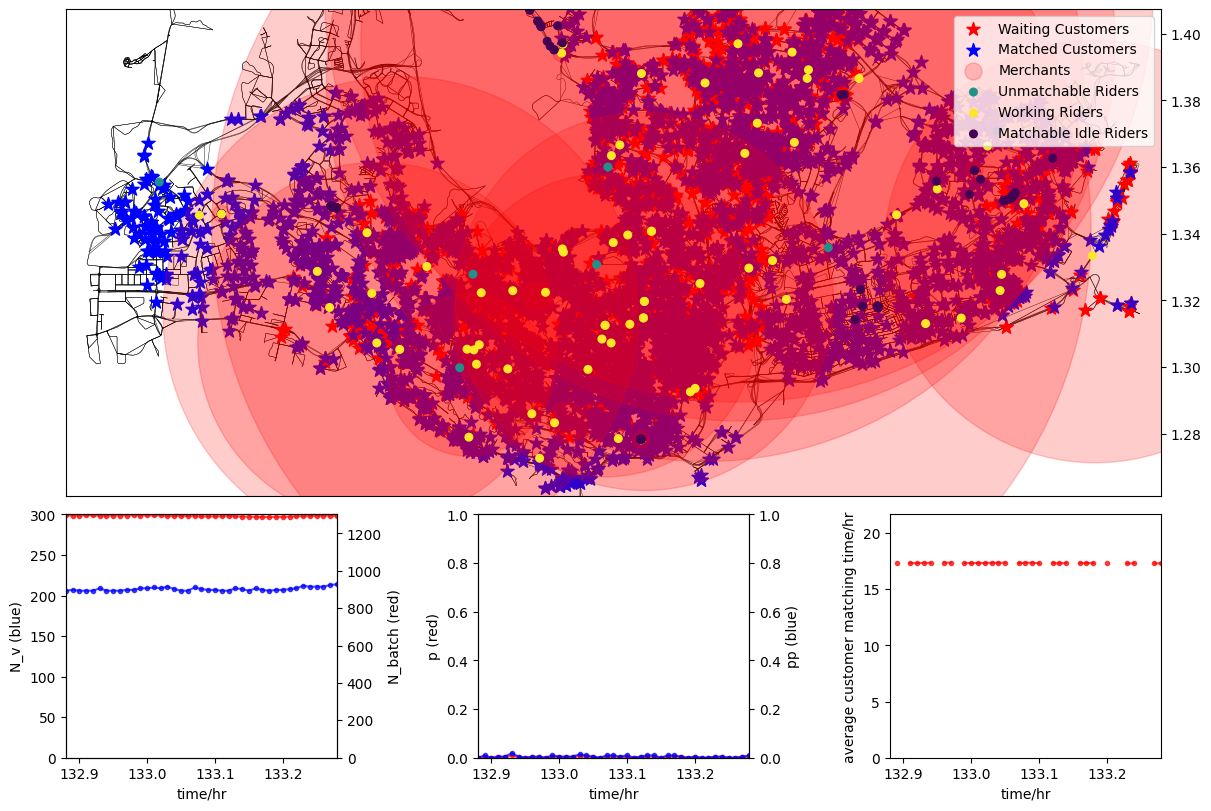

rider 235 completed! time:26.00
rider 14 completed! time:2.46
rider 225 completed! time:1.78
rider 76 completed! time:82.21
rider 26 completed! time:163.55
rider 283 completed! time:39.63
rider 42 completed! time:3.12
rider 6 completed! time:1.14
rider 47 completed! time:1.57
rider 93 completed! time:1.13
rider 2 completed! time:13.41
rider 297 completed! time:9.92
rider 93 completed! time:1.30
rider 282 completed! time:2.19
rider 227 completed! time:25.79
rider 295 completed! time:1.46
rider 97 completed! time:1.61
rider 282 completed! time:1.01
rider 153 completed! time:1.07
rider 293 completed! time:2.52
rider 162 completed! time:42.67
rider 15 completed! time:25.27
rider 180 completed! time:5.64
rider 190 completed! time:17.67
rider 42 completed! time:1.84
rider 39 completed! time:1.25
rider 7 completed! time:1.87
rider 235 completed! time:1.24
rider 223 completed! time:9.63
rider 191 completed! time:1.59
rider 225 completed! time:1.32
rider 46 completed! time:2.91
rider 100 comple

Process SpawnPoolWorker-8:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
Process SpawnPoolWorker-4:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 108, in run
    s

ed! time:2.85
rider 6 completed! time:3.51
rider 20 completed! time:1.97
rider 42 completed! time:1.20
rider 89 completed! time:1.68
rider 109 completed! time:1.51
rider 275 completed! time:7.40
rider 190 completed! time:36.58
rider 285 completed! time:1.65
rider 87 completed! time:13.59
rider 240 completed! time:17.35
rider 95 completed! time:39.68
rider 251 completed! time:42.45
rider 22 completed! time:2.32
rider 3 completed! time:2.12
rider 88 completed! time:28.21
rider 129 completed! time:1.34
rider 233 completed! time:1.30
rider 272 completed! time:23.03
rider 123 completed! time:1.04
rider 299 completed! time:1.61
rider 235 completed! time:28.81
rider 148 completed! time:4.85
rider 194 completed! time:2.34
rider 282 completed! time:16.24
rider 289 completed! time:1.57
rider 233 completed! time:1.54
rider 158 completed! time:1.35
rider 69 completed! time:3.10
rider 61 completed! time:1.20
rider 4 completed! time:2.45
rider 56 completed! time:1.40
rider 218 completed! time:2.18
r

rider 0 completed! time:1.30
rider 194 completed! time:2.02
rider 45 completed! time:4.82
rider 55 completed! time:58.59
rider 72 completed! time:56.90
rider 130 completed! time:44.59
rider 212 completed! time:1.80
rider 299 completed! time:2.49
rider 285 completed! time:1.60
rider 293 completed! time:1.10
rider 69 completed! time:2.44
rider 56 completed! time:1.36
rider 193 completed! time:1.93
rider 6 completed! time:10.14
rider 0 completed! time:4.09
rider 298 completed! time:2.78
rider 140 completed! time:51.01
rider 73 completed! time:2.23
rider 223 completed! time:22.45
rider 208 completed! time:12.34
rider 161 completed! time:1.82
rider 265 completed! time:4.86
rider 234 completed! time:6.29
rider 194 completed! time:2.55
rider 275 completed! time:13.69
rider 161 completed! time:2.40
rider 89 completed! time:1.77
rider 120 completed! time:26.46
rider 137 completed! time:2.38
rider 295 completed! time:1.48
rider 42 completed! time:1.24
rider 69 completed! time:2.31
rider 244 comp

Process SpawnPoolWorker-3:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/queues.py", line 356, in get
    res = self._reader.recv_bytes()
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterru

1.21
rider 183 completed! time:11.30
rider 199 completed! time:9.32
rider 239 completed! time:2.33
rider 144 completed! time:1.06
rider 120 completed! time:3.84
rider 175 completed! time:1.08
rider 8 completed! time:13.13
rider 39 completed! time:1.73
rider 198 completed! time:8.42
rider 193 completed! time:1.46
rider 159 completed! time:2.92
rider 147 completed! time:17.83
rider 129 completed! time:1.13
rider 271 completed! time:19.83
rider 40 completed! time:3.01
rider 61 completed! time:1.46
rider 253 completed! time:2.26
rider 1 completed! time:5.72
rider 63 completed! time:1.47
rider 233 completed! time:2.19
rider 7 completed! time:1.78
rider 58 completed! time:54.41
rider 61 completed! time:1.43
rider 232 completed! time:1.36
rider 227 completed! time:1.26
rider 274 completed! time:1.67
rider 56 completed! time:2.52
rider 289 completed! time:1.27
rider 281 completed! time:26.11
rider 46 completed! time:2.14
rider 256 completed! time:2.92
rider 140 completed! time:14.36
rider 142 

Process SpawnPoolWorker-2:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/queues.py", line 355, in get
    with self._rlock:
  File "/opt/anaconda3/envs/modeling/lib/python3.8/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt


1.67
rider 206 completed! time:42.04
rider 270 completed! time:3.08
rider 296 completed! time:58.91
rider 7 completed! time:1.62
rider 299 completed! time:1.98
rider 273 completed! time:26.82
rider 56 completed! time:0.89
rider 124 completed! time:12.39
rider 7 completed! time:1.73
rider 89 completed! time:1.76
rider 65 completed! time:1.25
rider 54 completed! time:1.80
rider 93 completed! time:4.94
rider 256 completed! time:22.31
rider 291 completed! time:14.89
rider 297 completed! time:1.21
rider 216 completed! time:24.56
rider 286 completed! time:36.98
rider 289 completed! time:13.84
rider 137 completed! time:0.95
rider 299 completed! time:2.11
rider 32 completed! time:8.72
rider 194 completed! time:2.01
rider 54 completed! time:1.05
rider 53 completed! time:13.25
rider 265 completed! time:2.22
rider 7 completed! time:1.30
rider 153 completed! time:1.16
rider 122 completed! time:22.54
rider 212 completed! time:3.53
rider 297 completed! time:1.09
rider 175 completed! time:2.29
Remove

rider 29 completed! time:1.41
rider 179 completed! time:2.05
Removed customer No. 9754245989 becuase of no path from 4607458642
rider 276 completed! time:0.89
rider 287 completed! time:2.07
rider 108 completed! time:6.68
rider 298 completed! time:6.41
rider 3 completed! time:87.70
rider 225 completed! time:18.83
rider 82 completed! time:5.93
rider 113 completed! time:9.78
rider 197 completed! time:4.31
rider 286 completed! time:4.87
rider 271 completed! time:5.89
rider 293 completed! time:1.37
rider 285 completed! time:1.41
rider 299 completed! time:1.61
rider 227 completed! time:1.57
rider 153 completed! time:1.47
rider 180 completed! time:17.99
rider 20 completed! time:1.47
rider 56 completed! time:1.90
rider 236 completed! time:10.10
rider 44 completed! time:41.58
rider 87 completed! time:28.72
rider 154 completed! time:1.38
rider 137 completed! time:1.44
rider 23 completed! time:1.61
rider 43 completed! time:8.42
rider 285 completed! time:0.96
rider 290 completed! time:16.69
rider 

KeyboardInterrupt: 

 162 completed! time:2.38
rider 109 completed! time:1.20
rider 179 completed! time:1.58
rider 194 completed! time:2.45
rider 161 completed! time:2.30
rider 230 completed! time:18.57
rider 26 completed! time:32.31
rider 232 completed! time:1.28
rider 204 completed! time:7.72
rider 177 completed! time:51.47
rider 244 completed! time:3.80
rider 265 completed! time:1.70
rider 3 completed! time:29.99
rider 197 completed! time:20.94
rider 223 completed! time:4.92
rider 161 completed! time:1.74
rider 129 completed! time:0.88
rider 162 completed! time:2.64
rider 143 completed! time:1.38
rider 118 completed! time:7.78
rider 288 completed! time:5.84
rider 152 completed! time:2.31
rider 103 completed! time:2.12
rider 136 completed! time:4.48
rider 60 completed! time:25.45
rider 63 completed! time:2.10
rider 82 completed! time:13.44
rider 43 completed! time:13.50
rider 20 completed! time:1.56
rider 193 completed! time:2.35
rider 218 completed! time:2.83
rider 161 completed! time:1.46
rider 91 comp

rider 235 completed! time:1.21
rider 239 completed! time:18.06
rider 118 completed! time:1.37
rider 183 completed! time:1.55
rider 242 completed! time:1.74
rider 268 completed! time:1.68
rider 145 completed! time:26.54
rider 103 completed! time:3.84
rider 123 completed! time:1.14
rider 91 completed! time:2.22
rider 214 completed! time:1.34
rider 223 completed! time:4.74
rider 53 completed! time:1.79
rider 47 completed! time:1.26
rider 32 completed! time:2.60
Removed customer No. 4602296329 becuase of no path from 2684762386
rider 61 completed! time:2.79
rider 123 completed! time:1.19
rider 244 completed! time:2.65
rider 39 completed! time:3.46
rider 201 completed! time:6.27
rider 63 completed! time:2.77
rider 84 completed! time:2.13
rider 77 completed! time:2.20
rider 235 completed! time:1.54
rider 229 completed! time:3.83
rider 47 completed! time:1.44
rider 89 completed! time:33.83
rider 111 completed! time:3.27
rider 97 completed! time:1.27
rider 232 completed! time:2.25
rider 83 com

rider 114 completed! time:3.21
rider 133 completed! time:27.94
rider 61 completed! time:2.13
rider 85 completed! time:18.53
rider 233 completed! time:1.63
rider 1 completed! time:3.84
rider 5 completed! time:114.00
rider 42 completed! time:1.38
rider 61 completed! time:1.68
rider 173 completed! time:15.97
rider 297 completed! time:2.18
rider 35 completed! time:8.87
rider 149 completed! time:7.42
rider 54 completed! time:2.22
rider 143 completed! time:73.83
rider 18 completed! time:15.68
rider 297 completed! time:1.57
rider 52 completed! time:4.53
rider 274 completed! time:1.91
rider 237 completed! time:7.20
rider 239 completed! time:75.55
rider 227 completed! time:2.48
rider 143 completed! time:1.63
rider 226 completed! time:56.92
rider 1 completed! time:2.44
rider 270 completed! time:1.90
rider 261 completed! time:8.99
rider 54 completed! time:2.07
rider 65 completed! time:1.46
rider 201 completed! time:1.51
rider 154 completed! time:1.06
rider 89 completed! time:2.37
rider 144 comple

rider 81 completed! time:68.97
rider 141 completed! time:15.09
rider 54 completed! time:1.77
rider 14 completed! time:1.88
rider 20 completed! time:1.55
rider 91 completed! time:1.73
rider 298 completed! time:1.62
rider 244 completed! time:1.35
rider 175 completed! time:1.96
rider 265 completed! time:1.09
rider 171 completed! time:3.37
rider 136 completed! time:1.34
rider 37 completed! time:103.85
rider 114 completed! time:1.37
rider 42 completed! time:1.68
rider 192 completed! time:2.08
rider 144 completed! time:1.74
rider 14 completed! time:2.06
rider 39 completed! time:2.22
rider 108 completed! time:19.95
rider 159 completed! time:7.17
rider 129 completed! time:2.04
rider 271 completed! time:2.20
rider 137 completed! time:1.33
rider 36 completed! time:6.09
rider 220 completed! time:0.83
rider 93 completed! time:2.07
rider 256 completed! time:7.57
rider 274 completed! time:1.00
rider 123 completed! time:2.14
rider 143 completed! time:0.92
rider 293 completed! time:12.25
rider 152 com

rider 89 completed! time:1.54
rider 218 completed! time:14.50
rider 291 completed! time:4.82
rider 194 completed! time:1.21
rider 4 completed! time:2.91
rider 22 completed! time:3.41
rider 71 completed! time:17.06
rider 295 completed! time:1.70
rider 39 completed! time:2.98
rider 212 completed! time:2.08
rider 270 completed! time:30.11
rider 101 completed! time:7.54
rider 77 completed! time:9.13
rider 39 completed! time:2.09
rider 188 completed! time:33.63
rider 193 completed! time:2.17
rider 46 completed! time:11.69
rider 20 completed! time:1.75
rider 83 completed! time:44.85
rider 293 completed! time:1.59
rider 78 completed! time:86.35
rider 299 completed! time:1.56
rider 14 completed! time:1.66
rider 266 completed! time:54.10
rider 222 completed! time:2.44
rider 242 completed! time:9.58
rider 153 completed! time:1.25
rider 91 completed! time:1.79
rider 253 completed! time:2.04
Removed customer No. 1301396827 becuase of no path from 2327166645
rider 192 completed! time:6.55
rider 211

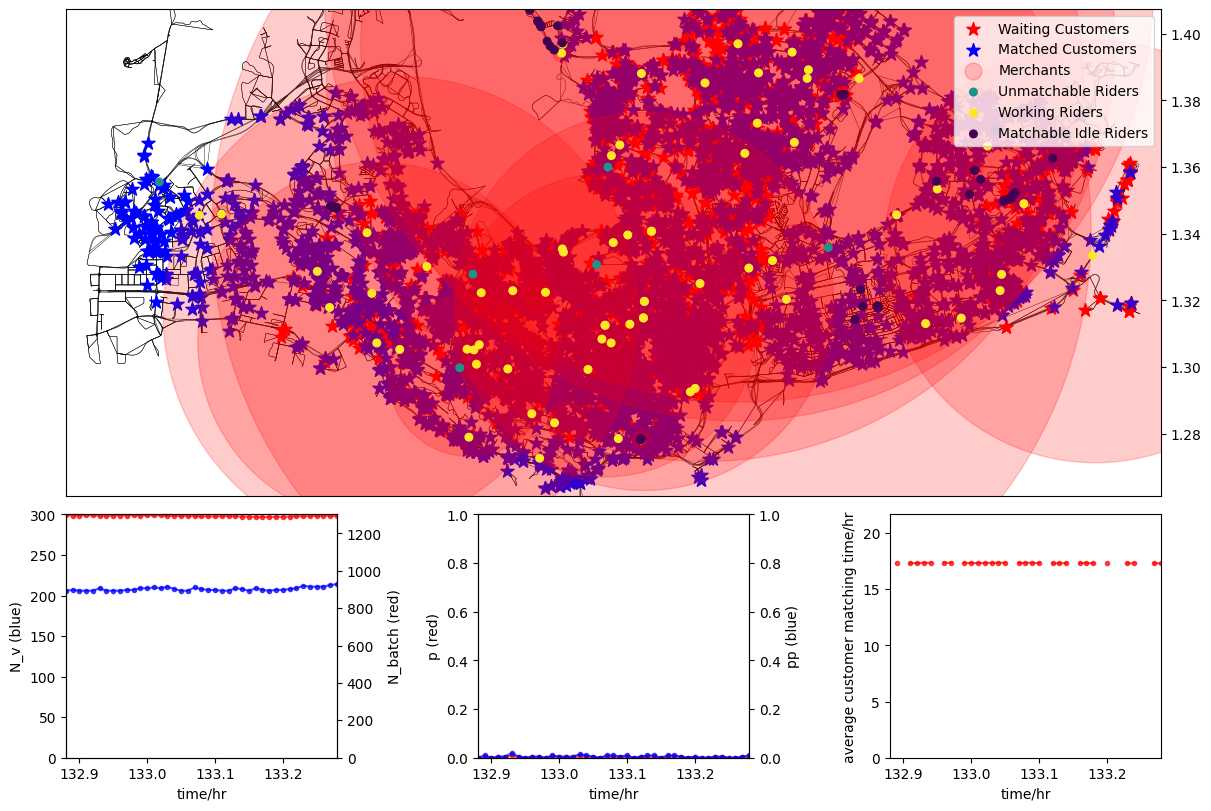

In [15]:
# # marking the x-axis and y-axis
fig = plt.figure(constrained_layout=True, figsize=[12, 8])
gs = fig.add_gridspec(3, 3)
ax0 = fig.add_subplot(gs[:2, :3])
ox.plot.plot_graph(
    G_sgp, ax=ax0, node_size=0, bgcolor='w', edge_color='k',
    edge_linewidth=.3, save=0, show=False, close=False
)
# nx.draw_networkx(G_sgp, pos=pos, ax=ax0, node_size=15, node_color='gray', with_labels=False)
ax = ax0.twinx()
ax.set_xlim(ax0.get_xlim())
ax.set_ylim(ax0.get_ylim())
ax.set_aspect((north - south)*aspect_ratio / (east - west))

ax2 = fig.add_subplot(gs[2, 0])
ax2.set_ylabel('N_v (blue)')
ax2.set_xlabel('time/hr')
ax3 = ax2.twinx()
ax3.set_ylabel('N_batch (red)')
ax3.set_xlabel('time/hr')
ax4 = fig.add_subplot(gs[2, 1])
ax4.set_ylabel('p (red)')
ax4.set_xlabel('time/hr')
ax4.set_ylim([0, 1])
ax5 = ax4.twinx()
ax5.set_ylabel('pp (blue)')
ax5.set_xlabel('time/hr')
ax5.set_ylim([0, 1])
ax6 = fig.add_subplot(gs[2, 2])
ax6.set_ylabel('average customer matching time/hr')
ax6.set_xlabel('time/hr')

# plt.tight_layout()


scat2 = ax.scatter([], [], color='red', marker='*', s=100, label='Waiting Customers')  # for waiting customers
scat3 = ax.scatter([], [], color='blue', marker='*', s=100, label='Matched Customers')  # for matched customers
scat4 = ax.scatter([], [], color='red', alpha=0.2, label='Merchants', s=150)  # for merchants

# riders
color = np.ones(N) * 0.5
scat = ax.scatter(-10*np.ones(len(rider_set)), -10*np.ones(len(rider_set)), s=30, c=np.ones(N) * 0.5, vmin=0, vmax=1, label='Unmatchable Riders')
ax.scatter(-10*np.ones(len(rider_set)), -10*np.ones(len(rider_set)), s=30, c=np.ones(N), vmin=0, vmax=1, label='Working Riders')
ax.scatter(-10*np.ones(len(rider_set)), -10*np.ones(len(rider_set)), s=30, c=np.zeros(N), vmin=0, vmax=1, label='Matchable Idle Riders')
ax.legend(loc='upper right')

line2, = ax2.plot([], [], 'b.-', alpha=0.7)
line3, = ax3.plot([], [], 'r.-', alpha=0.7)
line4, = ax4.plot([], [], 'r.-', alpha=0.7)
line5, = ax5.plot([], [], 'b.-', alpha=0.7)
line6, = ax6.plot([], [], 'r.-', alpha=0.7)

while c <= 9000:
    idle_rider_IDs = []
    for i in range(N):
        if rider_set[i].state=='idle' and rider_set[i].if_matchable:
            idle_rider_IDs.append(rider_set[i].ID)

    q = q_bar * cR**2 / Delta**2
    virtual_plat.acquire_order(q)

    if int(c%match_period)==0:
        matched_batches, matched_rider_IDs, matched_merchants, avg_W_cq = virtual_plat.match(
            idle_rider_IDs, rider_set
        )
    else:
        matched_batches, matched_rider_IDs, matched_merchants, avg_W_cq = np.array([]), [], [], np.nan

    num_matched_cust = matched_batches.size if int(c%match_period)==0 else np.nan
    try:
        p = num_matched_cust / (num_matched_cust + virtual_plat.num_accumulated_order/k)
    except:
        # when there is no order
        p = np.nan
    num_matched_rider_IDs = num_matched_cust // k
    try:
        pp = num_matched_rider_IDs / len(idle_rider_IDs)
    except:
        pp = np.nan

    # move use single processor
#     rider_set = move_rider(
#         rider_set, t_resolution, matched_rider_IDs, matched_batches, matched_merchants, dec_var
#     )
    # for multiprocessing, uncomment the following lines
    moved_rider_set = move_all_riders()
    moved_rider_set = [item for sublist in moved_rider_set for item in sublist]
    rider_set = moved_rider_set

    # update delivered customers
    delivered_customers_set = []
    for each_rider in rider_set:
        delivered_customers_set.append(each_rider.newly_finished_destination)

    for delivered_customer in delivered_customers_set:
        if delivered_customer in list(virtual_plat.matched_customer_df['node_ID']):
            virtual_plat.matched_customer_df = virtual_plat.matched_customer_df.drop(
                virtual_plat.matched_customer_df.loc[
                    virtual_plat.matched_customer_df['node_ID']==delivered_customer, 'waiting_time'
                ].astype(float).idxmax()
            )
    virtual_plat.matched_customer_df.index = range(virtual_plat.matched_customer_df.shape[0])

    time_now = c * t_resolution
    x_axis.append(time_now)
    num_idle_rider_IDs_set.append(len(idle_rider_IDs))
    num_accumulated_batch_set.append(virtual_plat.num_accumulated_order/k)  # continuous
    p_set.append(p)
    pp_set.append(pp)
    avg_W_cq_set.append(avg_W_cq)

    if c>=500 and c%1==0:
        # plot customers
        if virtual_plat.customer_df.shape[0]>0:
            cust_pos = np.array(virtual_plat.customer_df[['position_x', 'position_y']].to_numpy())
            scat2.set_offsets(cust_pos)
        if virtual_plat.matched_customer_df.shape[0] > 0:
            cust_pos_m = np.array(virtual_plat.matched_customer_df[['position_x', 'position_y']].to_numpy())
            scat3.set_offsets(cust_pos_m)

        # plot riders
        for i in range(N):
            if rider_set[i].state == 'idle' and rider_set[i].if_matchable:
                color[i] = 0
            elif rider_set[i].state == 'working' or rider_set[i].state == 'stop':
                color[i] = 1
            elif rider_set[i].state == 'idle' and rider_set[i].if_matchable==False:
                color[i] = 0.5
        scat.set_array(color)
        scat.set_offsets(
            np.array( [ [rider_set[i].position[0], rider_set[i].position[1]] for i in range(N)] )
        )

        # plot merchants
        merchant_pos = [[get_node_xy(i)[0], get_node_xy(i)[1]] for i in merchant_node_set]
        scat4.set_offsets(np.array(merchant_pos))
        acc_orders_by_merchant = []
        for i in merchant_node_set:
            acc_orders_by_merchant.append(virtual_plat.customer_df.loc[virtual_plat.customer_df['merchant_node']==i].shape[0])
        scat4.set_sizes(150 + np.array(acc_orders_by_merchant)**2)

        line2.set_data(x_axis, num_idle_rider_IDs_set)
        ax2.set_ylim([min(num_idle_rider_IDs_set), N])
        line3.set_data(x_axis, num_accumulated_batch_set)
        ax3.set_ylim([0, max(num_accumulated_batch_set)])
        line4.set_data(x_axis, p_set)
        line5.set_data(x_axis, pp_set)
        line6.set_data(x_axis, avg_W_cq_set)

        ax2.set_xlim([max(0, time_now - 0.4), time_now])
        ax3.set_xlim([max(0, time_now - 0.4), time_now])
        ax4.set_xlim([max(0, time_now - 0.4), time_now])
        ax5.set_xlim([max(0, time_now - 0.4), time_now])
        ax6.set_xlim([max(0, time_now - 0.4), time_now])
        if np.isnan(np.nanmax(avg_W_cq_set))==False:
            ax6.set_ylim([0, 1.2 * np.nanmax(avg_W_cq_set)])

        display.clear_output(wait=True)
        display.display(plt.gcf())

        fig.savefig('./res_img/%i%.4f.png'%(time_now//10, time_now-time_now//10*10 ), dpi=75)
    c += 1


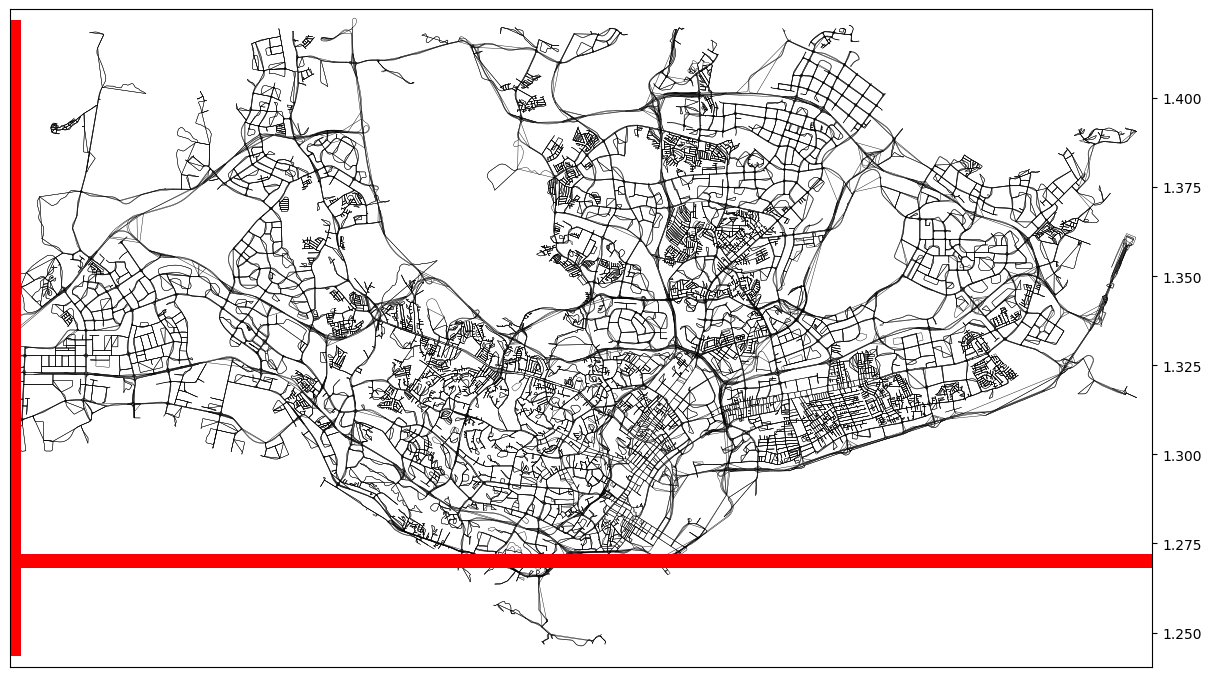

In [21]:
fig = plt.figure(constrained_layout=True, figsize=[12, 10])
gs = fig.add_gridspec(3, 3)
ax0 = fig.add_subplot(gs[:2, :3])

ox.plot.plot_graph(
    G_sgp, ax=ax0, node_size=0, bgcolor='w', edge_color='k',
    edge_linewidth=.3, save=0, show=False, close=False, bbox = (north, south, east, west)
)
ax0.plot([west*1.00001, west*1.00001], [north, south], 'b', lw=10)
ax0.plot([west, east], [south*1.02, south*1.02], 'b', lw=10)

ax = ax0.twinx()
# ax.set_ylim(ax0.get_ylim())
ax.set_aspect((north - south)*1.84 / (east - west))

ax.plot([west*1.00001, west*1.00001], [north, south], 'r', lw=10)
ax.plot([west, east], [south*1.02, south*1.02], 'r', lw=10)

In [17]:
# # make gif
# import glob
# from PIL import Image
# def make_gif(frame_folder):
#     frames = [Image.open(image) for image in sorted(glob.glob(f"{frame_folder}/*.png"))]
#     frame_one = frames[0]
#     frame_one.save('./res_img/demo0.gif', format="GIF", append_images=frames,
#                save_all=True, duration=35, loop=0)
    

# make_gif("./res_img/")

In [1]:
import cv2
import numpy as np
import glob

img_array = []
for filename in sorted(glob.glob("res_img/*.png")):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)


out = cv2.VideoWriter('./res_img/project_sgp.mp4',cv2.VideoWriter_fourcc('m', 'p', '4', 'v') , 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()



In [2]:
import os
for i in sorted(glob.glob("res_img/*.png")):
    os.remove(i)